In [6]:
# %matplotlib ipympl
# %matplotlib notebook
# %matplotlib qt
import pandas
import pathlib
import re
import numpy as np
# import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt
from matplotlib import animation
import json
from typing import Tuple

cwd = pathlib.Path.cwd()

G = 6.67408e-11
YEARS = 1
SCALE = 1
SECONDS = 60*60*24  # number of seconds in a day
tseconds = 365*SECONDS  # number of days
X = RN = 0  # I prefer doing this rather then using the numerical index
Y = VN = 1  # now I can plug these in and remind myself what this physically represents rather then remember which index I'm calling
dt = SECONDS



Classes

In [7]:
class Wanderer():
    '''
    Yes there are a number of variables that with Python I can easily access, but I made them private
    with methods to get ahold of them for purposes of 1) clarity and 2) safty. I don't want to accidentally
    access a variable, 
    '''
    def __init__(self, name: str, mass: float, x0: float, y0: float, vx0: float, vy0: float) -> None:

        self._name = name
        self._mass = mass
        self.rn = np.array([[x0, y0]])
        self.vn = np.array([[vx0, vy0]])
        self.clear_drdv()

        self._store_dv = np.zeros(shape = (1, 2))
        self._store_dr = np.zeros(shape = (1, 2))

        self.n0 = np.zeros(shape = (2, 2))
        self.n1 = np.zeros(shape = (2, 2))
        self.n2 = np.zeros(shape = (2, 2))

    
    def clear_drdv(self):
        self._dr = np.zeros(shape = (4, 2))
        self._dv = np.zeros(shape = (4, 2))

    
    def store_drdv(self, dr: np.array, dv: np.array):
        '''
        '''
        self._store_dr = dr
        self._store_dv = dv


    def set_drdv(self, k: int, dr: list, dv: list):
        '''
        '''
        self._dr[k] = dr
        self._dv[k] = dv

    
    def GMass(self, G):
        self.gass = self._mass * G


    def get_drdv(self) -> Tuple[np.array, np.array]:
        '''
        Just returns the dr and dv attributes.
        '''
        return self._dr, self._dv
    

    def get_kth(self, k: int) -> Tuple[np.array, np.array]:
        '''
        '''
        return self._dr[k], self._dv[k]
    

    def update_rnvn(self, rn, vn):
        '''
        '''
        self.rn = np.vstack([self.rn, rn])
        self.vn = np.vstack([self.vn, vn])


    def store_n(self, rn, vn, n: int):
        '''
        '''

        if n == 0:
            self.n0 = [rn, vn]
        elif n == 1:
            self.n1 = [rn, vn]
        elif n == 2:
            self.n2 = [rn, vn]
        



In [8]:
class NBodies():
    '''
    '''
    def __init__(self, system: tuple, tmax: float, h: float, G: float, delta: float = 1.0e-6) -> None:

        self.system = system
        self.tmax = tmax
        self.dt, self.h, self.h0 = 2*h, h, h
        self.G = G
        self.delta = delta
        self.to_many_iters = 0

        self.sun_array: np.array = np.zeros((2, 1))
        self.n = 0  # number of steps


    def acc(self, vec: np.array, dr:np.array, h: float) -> np.array:
        '''
        vec should be composed of vec[RN, M], so the 3th column is the mass.
        Yields the dv/dt = k value

        dv/dt = -G Sum[ Mj * (ri + (dri*h) - rj)/(ri + (dri*h) - rj)**3]
        '''

        an = np.zeros(shape = (vec.shape[0], 2))

        # ri = vec[:, RN:2]
        for i, ri in enumerate(vec):
            xi, yi, _ = ri

            xi = xi + dr[i][X]*h
            yi = yi + dr[i][Y]*h

            for j, rj in enumerate(vec):
                if j != i:
                    xj, yj, gmj = rj
                    
                    xj = xj + dr[j][X]*h
                    yj = yj + dr[j][Y]*h

                    r = np.sqrt((xi - xj)**2 + (yi - yj)**2)

                    a = gmj / r**3

                    an[i][X] += a * (xi - xj)
                    an[i][Y] += a * (yi - yj)

        return an

    
    def adaptive_time_step(self, n: int, max_attempts = 100):
        '''
        Finds the global h and adjusts that. It will fine to to the smallest needed h and expand only when needed.
        So basically look at each possible need for h, find the one with the best error, and use that for everyone

        https://www.youtube.com/watch?v=7eUyxD9f3dE

        A good youtube video on the adaptive method.

        The reason for the r1 = f(r0), r1 = f(r1), r2 = f(r0) is because we want to compare a double step vs two steps
        '''

        rn = np.zeros((len(self.system), 2))
        vn = np.zeros((len(self.system), 2))
        mn = np.zeros((len(self.system), 1))
        
        sun_index: int = 0

        body: Wanderer
        for i, body in enumerate(self.system):
            rn[i] = body.rn[n]
            mn[i] = body.gass
            vn[i] = body.vn[n]

            # if body._name in "Sun":
            #     sun_index = i
            #     mn[i] = body.gass
            #     rn[i][X] = self.sun_array[X]
            #     rn[i][Y] = self.sun_array[Y]
            #     vn[i][X] = self.sun_array[X]
            #     vn[i][Y] = self.sun_array[Y]
            # else:
            #     rn[i] = body.rn[n]
            #     mn[i] = body.gass
            #     vn[i] = body.vn[n]

        target_met = False
        for _ in range(max_attempts):
            self.dt = 2*self.h

            vec0 = np.hstack([rn, mn, vn])
            r1, v1 = self.RK4(vec0, self.h)
            
            vec1 = np.hstack([r1, mn, v1])
            r1, v1 = self.RK4(vec1, self.h)

            r2, v2 = self.RK4(vec0, 2*self.h)

            # r1[sun_index][X] = self.sun_array[X]
            # r1[sun_index][Y] = self.sun_array[Y]
            # r2[sun_index][X] = self.sun_array[X]
            # r2[sun_index][Y] = self.sun_array[Y]

            target_met = self.find_rho(r1, r2)

            if target_met:
                for i, body in enumerate(self.system):
                    body.update_rnvn(r1[i], v1[i])

                    # if body._name in "Sun":
                    #     body.update_rnvn(self.sun_array, self.sun_array)
                    # else:
                    #     body.update_rnvn(r1[i], v1[i])
                break
        
        else:
            print("iterated to oblivion")
            print(self.n)
            raise




    def find_rho(self, vec1: np.array, vec2: np.array, delta = 1.0e-2):
        '''
        '''
        
        def euc_dist(x: float):
            return np.sqrt(np.dot(x, x))

        diff = np.apply_along_axis(euc_dist, 1, vec1 - vec2)

        rho_mat = self.dt * delta * np.ones_like(diff)
        rho_mat = np.divide(rho_mat, diff, out = (2**4) * np.ones_like(rho_mat), where = diff != 0)

        # print(rho_mat) 
        rho = np.min(rho_mat)
        # print(f"rho = {rho}")
        # print(f"\n\nrho_ma:\n{rho_mat}")
        # print(f"\n\ndiff\n{diff}")
        # print(f"\n\nvec1\n{vec1}\n\nvec2\n{vec2}")
        # raise
        if rho < 1.:
            print(f"h = {self.h}, rho = {rho}")
            self.h = self.h * rho**(1/4.)
            print(f"New h = {self.h}")
            raise
            return False

        else:
            self.h = min(2*self.h, self.h * rho**(1/4.))
            # print(f"min h = {self.dt}")
            return True


    def orbits(self):
        '''
        This executes the iterations. First it sets the GMass, then it executes each time step, followed by finding the n+1 value
        of the function.

        It may seem overly complex to do it like this, where each step executes 
        '''
        body: Wanderer

        for body in self.system:
            body.GMass((-1) * self.G)
            body.clear_drdv()

        t = 0
        while (t < self.tmax):
            self.adaptive_time_step(self.n)
            self.n += 1
            t += self.dt


    def RK4(self, vec: np.array, h0: float):
        '''
        takes a vector input composed of vec[RN, M, VN], a total of Nx5 matrix
        '''
        dr = np.zeros(shape = (vec.shape[0], 4, 2))
        dv = np.zeros(shape = (vec.shape[0], 4, 2))

        v: np.array = vec[:, 3:5]
        r: np.array = vec[:, 0:2]
        rm: np.array = vec[:, 0:3]

        for k_iter in range(4):
            kn: int = k_iter - 1
            if (kn < 0):
                kn = 0  # the k values for a given body are set to 0, so indexing with kn = 0 and k = 0 means the return values are 0.
                        # it's a little bit of work to be super lazy: I can use the same function over and over with no alteration, just
                        # need to make sure that the tables are set to 0 at the start of the loop
            
            h = h0 if ((k_iter == 1) or (k_iter == 3)) else h0/2

            dr_0: np.array = dr[:, kn, :]
            dv_0: np.array = dv[:, kn, :]

            dr_k: np.array = self.vel(v, dv_0, h)
            dv_k: np.array = self.acc(rm, dr_0, h)

            for i in range(dr_k.shape[0]):
                dr[i][k_iter][X] = dr_k[i][X]
                dr[i][k_iter][Y] = dr_k[i][Y]
                
                dv[i][k_iter][X] = dv_k[i][X]
                dv[i][k_iter][Y] = dv_k[i][Y]

        v = v + (dv[:, 0, :] + 2*dv[:, 1, :] + 2*dv[:, 2, :] + dv[:, 3, :]) * (1/6.0)
        r = r + (dr[:, 0, :] + 2*dr[:, 1, :] + 2*dr[:, 2, :] + dr[:, 3, :]) * (1/6.0)

        return r, v


    def vel(self, vec: np.array, dv: np.array, h: float) -> np.array:
        '''
        Yields the dr/dt = k value

        dr/dt = v + (dv/dt)*h
        '''
        return vec + h*dv




Other methods

In [9]:
def import_bodies() -> tuple:
    '''
    Reads the AstronomicalObjects.json and establishes a Wanderer object for each of them.
    '''
    with open(cwd / "AstronomicalObjects.json", 'r') as json_file:
        system = []

        json_data = json.load(json_file)

        system_data = json_data["System"]

        for _, obj in system_data.items():
            body = Wanderer(obj["name"], obj["m"], obj["x0"], obj["y0"], obj["vx0"], obj["vy0"])

            system.append(body)

        return tuple(system)

def write_csv():
    '''
    '''
    

Adaptive Time Step

In [10]:
system = import_bodies()
nbodies = NBodies(system, tseconds, dt, G)
nbodies.orbits()


h = 86400, rho = 0.058996244452032436
New h = 42581.38999272061
h = 42581.38999272061, rho = 0.029075718670345748
New h = 17583.383511656983
h = 17583.383511656983, rho = 0.012006407314207776
New h = 5820.4386610497195
h = 5820.4386610497195, rho = 0.003974352107237843
New h = 1461.4107644634569
h = 1461.4107644634569, rho = 0.000997890586864788
New h = 259.74251026659334
h = 259.74251026659334, rho = 0.0001773591739614871
New h = 29.97481061069665
h = 29.97481061069665, rho = 2.046760710870411e-05
New h = 2.0161517435651377
h = 2.0161517435651377, rho = 1.376682651802781e-06
New h = 0.0690608112498502
h = 0.0690608112498502, rho = 4.715657989064622e-08
New h = 0.0010176940855305455
h = 0.0010176940855305455, rho = 6.949089010109685e-10
New h = 5.225155496050003e-06
h = 5.225155496050003e-06, rho = 3.567876747046838e-12
New h = 7.181277018324023e-09
h = 7.181277018324023e-09, rho = 4.903569148736188e-15
New h = 1.900333200766084e-12
h = 1.900333200766084e-12, rho = 1.2975986348693186e-

RuntimeError: No active exception to reraise

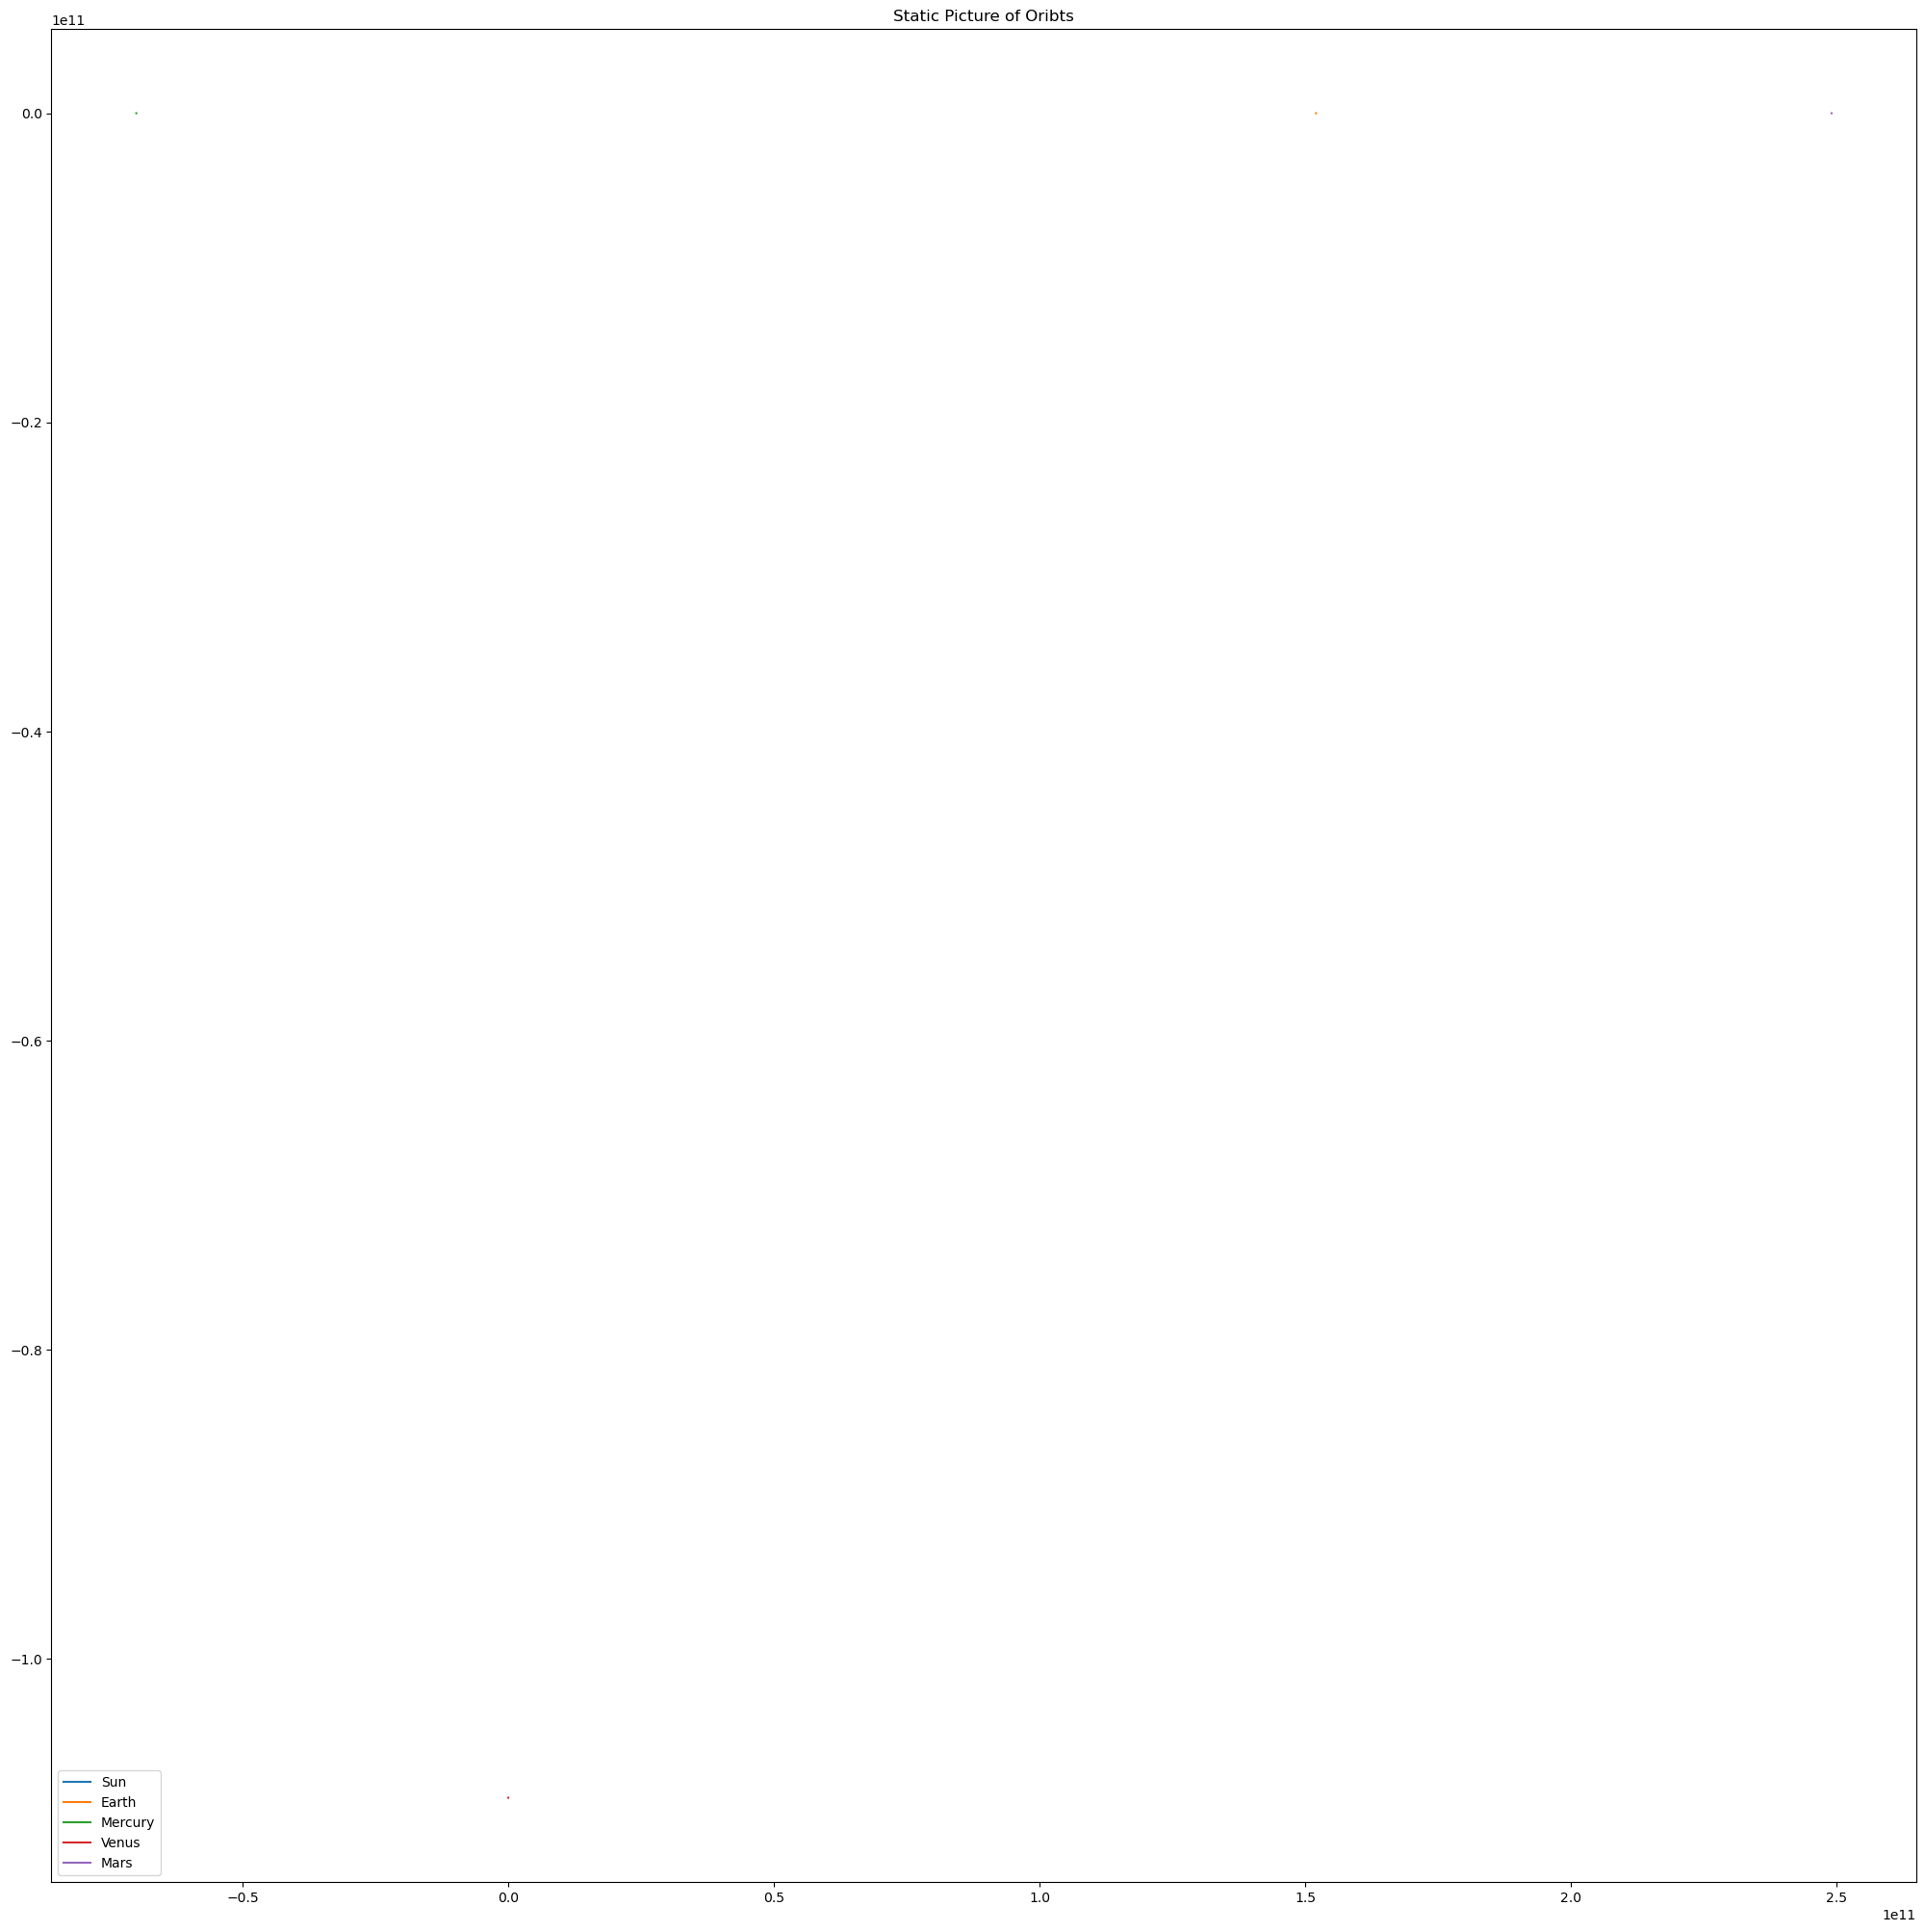

In [ ]:
body: Wanderer
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
# plt.rcParams["figure.figsize"] = (75, 75)
plt.figure(figsize = (25, 25))

for body in system:
    plt.plot(body.rn[:, X], body.rn[:, Y], label = body._name)
    # print(body.rn)

plt.legend()
plt.title("Static Picture of Oribts")
plt.savefig(str(cwd / f"Static_Orbits_for_{YEARS}_years.png"))
plt.show()

In [ ]:
# def euc_dist(x: float):
#     return np.sqrt(np.dot(x, x))

# z1 = np.random.rand(3, 2)
# z2 = np.random.rand(3, 2)


# diff = np.apply_along_axis(euc_dist, 1, z1 - z2)

# print(f"{z1}\n\n{z2}\n\n{diff}")